# Modeling spike data with `multidms.jaxmodels`

In [10]:
import multidms
import multidms.jaxmodels

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy
import os

In [11]:
# simulated_mutfile = f"data/simulated_data/simulated_mutations_{replicate}.csv"

Papermill params

In [12]:
replicate = "lib_1"
func_score_type = "loose_bottle"
do_truncate_nonsense = True
output_dir = 'simulations_output'

reference = 'h1'
l2reg = 1e-4
fusionreg = 0.5
block_iters = 10
block_tol = 0

ge_tol = 0#1e-4
ge_maxiter = 100#1000
ge_maxls = 30

cal_tol = 0#1e-4
cal_maxiter = 100#1000
cal_maxls = 30

loss_fn = "functional_score_loss"
beta_naught_init = {
    "h1": 5.0,
    "h2": 0.0
}
warmstart = False
beta_clip = (-10, 10)
# loss_fn = "count_loss"

loss_kwargs = {"δ": 1.0}
# loss_kwargs = {}

# global_epistasis = "Identity"
global_epistasis = "Sigmoid"

functional_score_min = -6
functional_score_max = 2
pseudocount = 0.
min_pre_count = 200
min_post_count = 1

In [13]:
loss_fn = getattr(multidms.jaxmodels, loss_fn)
global_epistasis = getattr(multidms.jaxmodels, global_epistasis)()

In [14]:
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

## Data loading/filtering

Read raw data, pick replicate, and aggregate counts

In [28]:
pd.read_csv("../scaled_down_parameter_output/simulated_bottleneck_cbf.csv", keep_default_na=False).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121504 entries, 0 to 121503
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   library             121504 non-null  object 
 1   pre_sample          121504 non-null  object 
 2   func_score_type     121504 non-null  object 
 3   aa_substitutions    121504 non-null  object 
 4   func_score          121504 non-null  float64
 5   func_score_var      121504 non-null  float64
 6   pre_count           121504 non-null  int64  
 7   post_count          121504 non-null  int64  
 8   pre_count_wt        121504 non-null  int64  
 9   post_count_wt       121504 non-null  int64  
 10  pseudocount         121504 non-null  float64
 11  n_aa_substitutions  121504 non-null  int64  
 12  homolog             121504 non-null  object 
dtypes: float64(3), int64(5), object(5)
memory usage: 12.1+ MB


In [ ]:
# df = (
#     pd.read_csv(
#         "../scaled_down_parameter_output/simulated_functional_scores.csv", 
#         keep_default_na=True
#     )
#     .infer_objects()
#     .assign(
#         aa_substitutions = lambda x: x['aa_substitutions'].fillna('')
#     )
#     .assign(
#         n_subs = lambda x: x['aa_substitutions'].str.split().str.len()
#     )
#     .rename(
#         columns={
#             "library": "replicate",
#             "homolog": "condition",
#         }
#     )
# )
# df


,replicate,condition,aa_substitutions,func_score_type,func_score,pre_sample,func_score_var,pre_count,post_count,pre_count_wt,post_count_wt,pseudocount,n_aa_substitutions,variant_class,latent_phenotype,n_subs
0,lib_1,h1,L33P,observed_phenotype,0.008957,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1 nonsynonymous,5.253866,1
1,lib_1,h1,N3V F16S,observed_phenotype,-0.031679,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,>1 nonsynonymous,4.413085,2
2,lib_1,h1,,observed_phenotype,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,wildtype,5.000000,0
3,lib_1,h1,L2Q H31*,observed_phenotype,-5.929515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,stop,-5.282384,2
4,lib_1,h1,N3Y L17N D18I E27R,observed_phenotype,-5.039159,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,>1 nonsynonymous,-1.707815,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182251,lib_2,h2,N3* L23V M29V,tight_bottle,-6.406314,pre-selection,4.255248,22.0,0.0,690497.0,1301494.0,0.5,3.0,stop,-8.252959,3
182252,lib_2,h2,V39* F45V,tight_bottle,-6.406314,pre-selection,4.255248,22.0,0.0,690497.0,1301494.0,0.5,2.0,stop,-7.193444,2
182253,lib_2,h2,M29S Y38H L44A,tight_bottle,2.159740,pre-selection,0.103493,22.0,189.0,690497.0,1301494.0,0.5,3.0,>1 nonsynonymous,3.096208,3
182254,lib_2,h2,V41N G48V,tight_bottle,-6.043744,pre-selection,4.281678,17.0,0.0,690497.0,1301494.0,0.5,2.0,>1 nonsynonymous,1.074724,2


In [35]:
# df = pd.read_csv("simulated_bottleneck_cbf.csv", keep_default_na=False)
df = pd.read_csv("../scaled_down_parameter_output/simulated_bottleneck_cbf.csv", keep_default_na=False)
# df = pd.read_csv("../scaled_down_parameter_output/simulated_functional_scores.csv", keep_default_na=False)
df.rename(
    columns={
        "library": "replicate",
        "homolog": "condition",
        "n_aa_substitutions": "n_subs",
    },
    inplace=True,
)
df

,replicate,pre_sample,func_score_type,aa_substitutions,func_score,func_score_var,pre_count,post_count,pre_count_wt,post_count_wt,pseudocount,n_subs,condition
0,lib_1,pre-selection,loose_bottle,N3S V39I S46G L49N,-0.877691,0.004955,853,828,721310,1286537,0.5,4,h1
1,lib_1,pre-selection,loose_bottle,G48A,-4.173100,0.008852,2614,258,721310,1286537,0.5,1,h1
2,lib_1,pre-selection,loose_bottle,,0.000000,0.000009,721310,1286537,721310,1286537,0.5,0,h1
3,lib_1,pre-selection,loose_bottle,R14W V15P E27P S46L,0.062447,0.004811,665,1239,721310,1286537,0.5,4,h1
4,lib_1,pre-selection,loose_bottle,K21F,-0.252152,0.002571,1352,2025,721310,1286537,0.5,1,h1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
121499,lib_2,pre-selection,tight_bottle,N3* L23V M29V,-6.406314,4.255248,22,0,690497,1301494,0.5,3,h2
121500,lib_2,pre-selection,tight_bottle,V39* F45V,-6.406314,4.255248,22,0,690497,1301494,0.5,2,h2
121501,lib_2,pre-selection,tight_bottle,M29S Y38H L44A,2.159740,0.103493,22,189,690497,1301494,0.5,3,h2
121502,lib_2,pre-selection,tight_bottle,V41N G48V,-6.043744,4.281678,17,0,690497,1301494,0.5,2,h2


<Axes: >

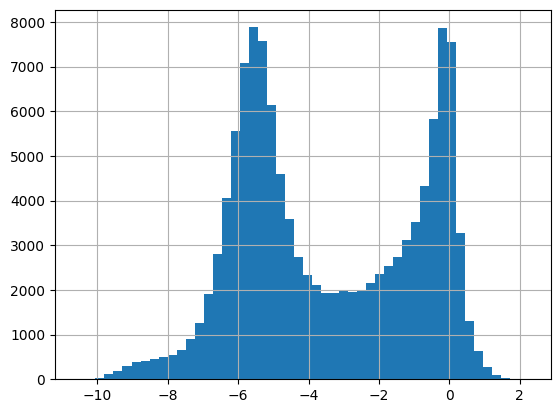

In [36]:
df.func_score.hist(bins=50)

In [37]:
df

,replicate,pre_sample,func_score_type,aa_substitutions,func_score,func_score_var,pre_count,post_count,pre_count_wt,post_count_wt,pseudocount,n_subs,condition
0,lib_1,pre-selection,loose_bottle,N3S V39I S46G L49N,-0.877691,0.004955,853,828,721310,1286537,0.5,4,h1
1,lib_1,pre-selection,loose_bottle,G48A,-4.173100,0.008852,2614,258,721310,1286537,0.5,1,h1
2,lib_1,pre-selection,loose_bottle,,0.000000,0.000009,721310,1286537,721310,1286537,0.5,0,h1
3,lib_1,pre-selection,loose_bottle,R14W V15P E27P S46L,0.062447,0.004811,665,1239,721310,1286537,0.5,4,h1
4,lib_1,pre-selection,loose_bottle,K21F,-0.252152,0.002571,1352,2025,721310,1286537,0.5,1,h1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
121499,lib_2,pre-selection,tight_bottle,N3* L23V M29V,-6.406314,4.255248,22,0,690497,1301494,0.5,3,h2
121500,lib_2,pre-selection,tight_bottle,V39* F45V,-6.406314,4.255248,22,0,690497,1301494,0.5,2,h2
121501,lib_2,pre-selection,tight_bottle,M29S Y38H L44A,2.159740,0.103493,22,189,690497,1301494,0.5,3,h2
121502,lib_2,pre-selection,tight_bottle,V41N G48V,-6.043744,4.281678,17,0,690497,1301494,0.5,2,h2


In [38]:
df.query(f"replicate == '{replicate}' & func_score_type == '{func_score_type}'", inplace=True)
df

,replicate,pre_sample,func_score_type,aa_substitutions,func_score,func_score_var,pre_count,post_count,pre_count_wt,post_count_wt,pseudocount,n_subs,condition
0,lib_1,pre-selection,loose_bottle,N3S V39I S46G L49N,-0.877691,0.004955,853,828,721310,1286537,0.5,4,h1
1,lib_1,pre-selection,loose_bottle,G48A,-4.173100,0.008852,2614,258,721310,1286537,0.5,1,h1
2,lib_1,pre-selection,loose_bottle,,0.000000,0.000009,721310,1286537,721310,1286537,0.5,0,h1
3,lib_1,pre-selection,loose_bottle,R14W V15P E27P S46L,0.062447,0.004811,665,1239,721310,1286537,0.5,4,h1
4,lib_1,pre-selection,loose_bottle,K21F,-0.252152,0.002571,1352,2025,721310,1286537,0.5,1,h1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
75884,lib_1,pre-selection,loose_bottle,V6N G7F H24K F34H,-3.642552,0.691489,21,3,678453,1379326,0.5,4,h2
75885,lib_1,pre-selection,loose_bottle,F16W A20*,-6.449907,4.259550,21,0,678453,1379326,0.5,2,h2
75886,lib_1,pre-selection,loose_bottle,F1S H24R,-0.599834,0.177221,20,27,678453,1379326,0.5,2,h2
75887,lib_1,pre-selection,loose_bottle,V15G L44Y,-6.309044,4.269479,19,0,678453,1379326,0.5,2,h2


In [39]:

# remove variants with too many deletions
df = df.loc[df.aa_substitutions.str.count("-") == 0, :]

df = df.groupby(["condition", "replicate", "aa_substitutions"]).agg(
    {"n_subs": "first", "pre_count": "sum", "post_count": "sum"}
    ).reset_index()

df

,condition,replicate,aa_substitutions,n_subs,pre_count,post_count
0,h1,lib_1,,0,721310,1286537
1,h1,lib_1,A10*,1,945,24
2,h1,lib_1,A10* C26L,2,104,3
3,h1,lib_1,A10* C26P W40T P43F,4,246,6
4,h1,lib_1,A10* E27* L33H,3,226,5
...,...,...,...,...,...,...
30432,h2,lib_1,Y47T,1,506,335
30433,h2,lib_1,Y47T G48S,2,395,13
30434,h2,lib_1,Y47T L49E,2,395,35
30435,h2,lib_1,Y47V,1,3242,6453


In [40]:
df.query("aa_substitutions == ''")

,condition,replicate,aa_substitutions,n_subs,pre_count,post_count
0,h1,lib_1,,0,721310,1286537
15204,h2,lib_1,,0,678453,1379326


In [41]:
df[df["aa_substitutions"].str.contains("G50W")]

,condition,replicate,aa_substitutions,n_subs,pre_count,post_count


Ah, G50W doesn't hit the threshold.

### Count filtering

Apply some thresholds to filter out low counts. We need pre-counts to be reasonably high to satisfy assumptions of the count-based loss function.

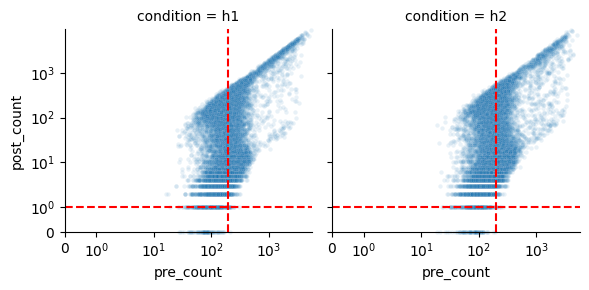

In [42]:
g = sns.relplot(
    x=df.pre_count[df.aa_substitutions != ""],
    y=df.post_count[df.aa_substitutions != ""],
    col=df.condition[df.aa_substitutions != ""],
    s=10, alpha=0.1,
    height=3, aspect=1,
    clip_on=False,
    )
plt.xlim(0, None)
plt.ylim(0, None)
plt.xscale("symlog", linthresh=1, linscale=0.5)
plt.yscale("symlog", linthresh=1, linscale=0.5)

for ax in g.axes.flat:
    condition = ax.get_title().split(" = ")[1]
    df_condition = df.query(f"(condition == @condition) & (aa_substitutions != '')")
    df.drop(index=df_condition.query("(pre_count < @min_pre_count) | (post_count < @min_post_count)").index, inplace=True)
    ax.axvline(min_pre_count, color="red", linestyle="--")
    ax.axhline(min_post_count, color="red", linestyle="--")

plt.tight_layout()
plt.show()

In [43]:
df.shape

(14073, 6)

### Mutation number filtering

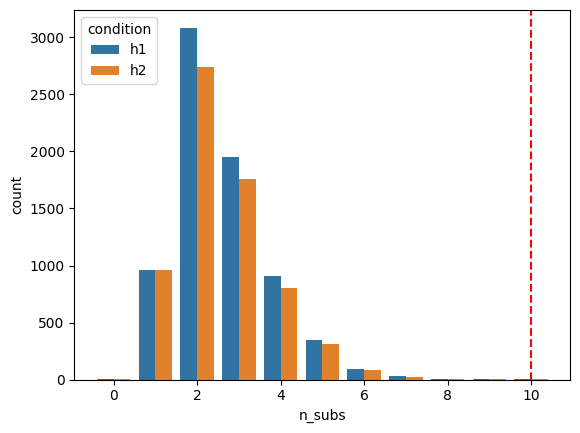

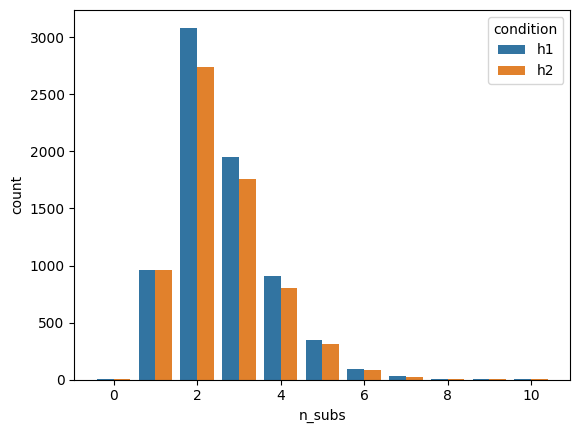

In [44]:
n_sub_thresh = 10

sns.countplot(data=df, x="n_subs", hue="condition", native_scale=True)
plt.axvline(n_sub_thresh, color="red", linestyle="--")
plt.show()

df = df.query("n_subs <= @n_sub_thresh")

sns.countplot(data=df, x="n_subs", hue="condition", native_scale=True)
plt.show()


In [45]:
df.shape

(14073, 6)

### Nonsense variants

Truncate nonsense variants to exlude any mutations downstream of the first nonsense mutation, and then filter to only nonsense variants with no missense mutation before first nonsense.

In [46]:
# # TEMP: cmopletetely remove nonsense
# df = df.loc[~df.aa_substitutions.str.contains("*", regex=False)]
# df.shape

In [47]:
def truncate_nonsense(row):
    if row.aa_substitutions:
        muts = row.aa_substitutions.split(" ")
        assert len(muts) == row.n_subs, row
        new_muts = []
        for mut in muts:
            new_muts.append(mut)
            if "*" in mut:
                break
        row.aa_substitutions = " ".join(new_muts)
        row.n_subs = len(new_muts)
    return row

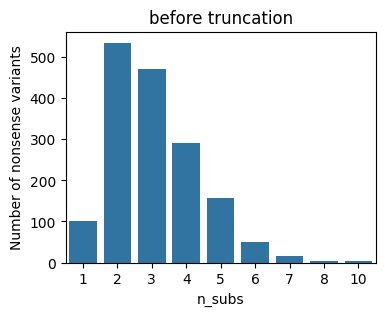

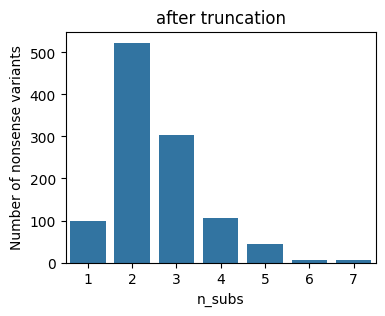

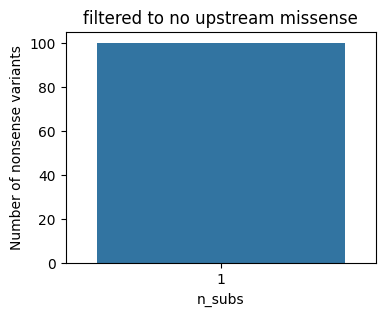

In [48]:
plt.figure(figsize=(4, 3))
sns.countplot(x=df.loc[df.aa_substitutions.str.contains("*", regex=False)].n_subs)
plt.ylabel("Number of nonsense variants")
plt.title("before truncation")
plt.show()

if do_truncate_nonsense:
    df = df.apply(truncate_nonsense, axis=1)
    # re-aggregate identical variants
    df = df.groupby(["condition", "replicate", "aa_substitutions"]).agg(
        {"n_subs": "first", "pre_count": "sum", "post_count": "sum"}
        ).reset_index()

    plt.figure(figsize=(4, 3))
    sns.countplot(x=df.loc[df.aa_substitutions.str.contains("*", regex=False)].n_subs)
    plt.ylabel("Number of nonsense variants")
    plt.title("after truncation")
    plt.show()

    df = df.loc[~(df.aa_substitutions.str.contains("*", regex=False) & (df.n_subs > 1)), :]

    plt.figure(figsize=(4, 3))
    sns.countplot(x=df.loc[df.aa_substitutions.str.contains("*", regex=False)].n_subs)
    plt.ylabel("Number of nonsense variants")
    plt.title("filtered to no upstream missense")
    plt.show()

### Compute functional scores

Note: $\log$ is more natural than $\log_2$ in the fitness-based model

/var/folders/3x/xgx592cd1036yjqqj8dnvnsh0000gn/T/ipykernel_32355/2872106849.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.func_score.clip(lower=functional_score_min, upper=functional_score_max, inplace=True)


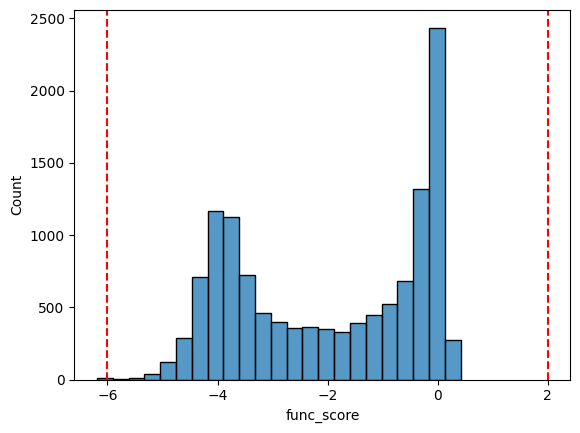

In [49]:
df["func_score"] = np.log(df["post_count"] + pseudocount) - np.log(df["pre_count"] + pseudocount)

def group_wt_ref(df_group):
    wts = df_group.query("aa_substitutions == ''")
    assert wts.shape[0] == 1, wts
    df_group.func_score = df_group.func_score.values - wts.func_score.values[0]
    return df_group

df = df.groupby(["condition", "replicate"]).apply(group_wt_ref, include_groups=False).reset_index(level=-1, drop=True).reset_index()

sns.histplot(df.func_score)
plt.axvline(functional_score_min, color="red", linestyle="--")
plt.axvline(functional_score_max, color="red", linestyle="--")
df.func_score.clip(lower=functional_score_min, upper=functional_score_max, inplace=True)
plt.show()

<Axes: xlabel='func_score', ylabel='Count'>

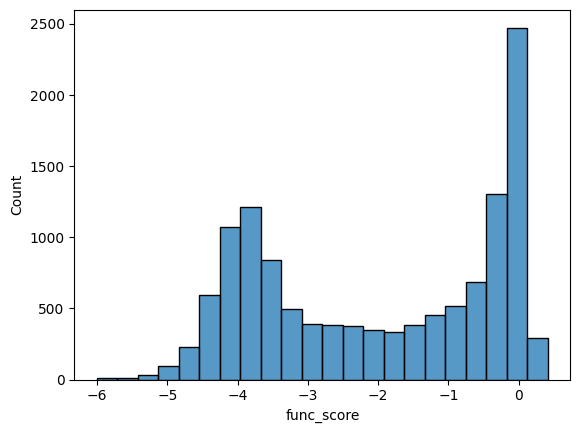

In [50]:
sns.histplot(df.func_score)

In [51]:
# how many unique mutations are seen in the dataset? Note that we need to split the space-separated strings in the aa_substitutions column and then explode the list into separate rows to count unique mutations.
df.aa_substitutions.str.split(" ").explode().nunique()

1201

In [52]:
50 * 20

1000

In [53]:
10 * 20

200

In [54]:
# check that G50W exists in the dataset
df[df["aa_substitutions"].str.contains("G50W")]

,condition,replicate,aa_substitutions,n_subs,pre_count,post_count,func_score


### Multidms data

Load as a multidms dataset, choosing a reference condition.

In [55]:
multidms_data = multidms.Data(
    df,
    alphabet=multidms.AAS_WITHSTOP_WITHGAP,
    reference=reference,
)

/Users/macdre/Matsengrp/projects/dms/.pixi/envs/default/lib/python3.13/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_array is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


In [56]:
# BA2_numbering = pd.read_csv("https://raw.githubusercontent.com/dms-vep/SARS-CoV-2_Omicron_BA.2_spike_DMS/main/results/site_numbering/site_numbering_map.csv", index_col="reference_site")
# BA2_numbering


# foo = multidms_data.site_map.join(BA2_numbering)

# bad_idxs = foo.Omicron_BA2 != foo.sequential_wt

# foo.loc[bad_idxs, :]

# # BA2_numbering.loc[BA2_numbering.sequential_wt != BA2_numbering.reference_wt, :]

Create a `jaxmodels.Data` object, containing the array data

In [57]:
data_sets = {
    d: multidms.jaxmodels.Data.from_multidms(multidms_data, d)
    for d in multidms_data.conditions
    }

# Display the reference condition data object
data_sets[multidms_data.reference]

Data(
  x_wt=i8[1000],
  X=BCOO(int8[6575, 1000], nse=16560),
  functional_scores=f64[6575],
  pre_count_wt=i64[],
  post_count_wt=i64[],
  pre_counts=i64[6575],
  post_counts=i64[6575]
)

In [58]:
data_sets

{'h1': Data(
   x_wt=i8[1000],
   X=BCOO(int8[6575, 1000], nse=16560),
   functional_scores=f64[6575],
   pre_count_wt=i64[],
   post_count_wt=i64[],
   pre_counts=i64[6575],
   post_counts=i64[6575]
 ),
 'h2': Data(
   x_wt=i8[1000],
   X=BCOO(int8[5968, 1000], nse=71414),
   functional_scores=f64[5968],
   pre_count_wt=i64[],
   post_count_wt=i64[],
   pre_counts=i64[5968],
   post_counts=i64[5968]
 )}

In [59]:
df.query("aa_substitutions == ''    ")

,condition,replicate,aa_substitutions,n_subs,pre_count,post_count,func_score
0,h1,lib_1,,0,721310,1286537,0.0
6576,h2,lib_1,,0,678453,1379326,0.0


In [60]:
for condition in multidms_data.conditions:
    print(data_sets[condition].pre_count_wt)
    print(data_sets[condition].post_count_wt)


721310
1286537
678453
1379326


# WARNING: random samples for testing if uncommented

In [61]:
# data_sets_OLD = data_sets

In [62]:
# import jax

# data_sets = {}

# for d in multidms_data.conditions:
#     # sample_slice = slice(0, len(data_sets_OLD[d].X) // 2)
#     sample_slice = slice(len(data_sets_OLD[d].X) // 2 + 1, None)
#     data_sets[d] = multidms.jaxmodels.Data(
#         data_sets_OLD[d].x_wt,
#         data_sets_OLD[d].pre_count_wt,
#         data_sets_OLD[d].post_count_wt,
#         jax.experimental.sparse.BCOO.fromdense(data_sets_OLD[d].X[sample_slice].todense()),
#         data_sets_OLD[d].pre_counts[sample_slice],
#         data_sets_OLD[d].post_counts[sample_slice],
#         data_sets_OLD[d].functional_scores[sample_slice],
#     )
#     assert (data_sets_OLD[d].X[sample_slice].todense() == data_sets[d].X.todense()).all(), f"Data mismatch for condition {d}: {data_sets_OLD[d].X[sample_slice]} and {data_sets[d].X}"



In [63]:
{d: int(data_sets[d].x_wt.sum()) for d in data_sets}

# {'Delta': 30, 'Omicron_BA1': 0, 'Omicron_BA2': 14}

{'h1': 0, 'h2': 10}

Plot the sums of the binary encodings of the variants

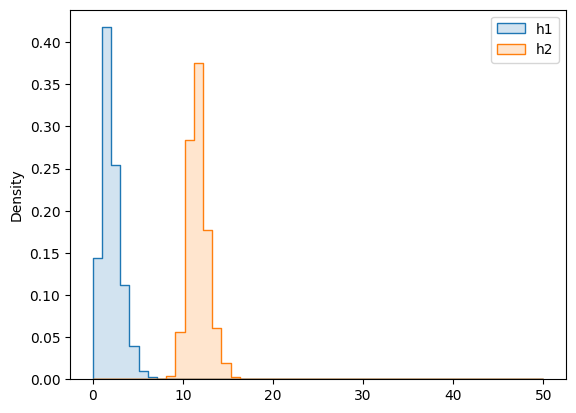

In [64]:
for d, data_set in data_sets.items():
    sns.histplot(x=data_set.X.sum(1, dtype=float).todense(), label=d, fill=True, alpha=0.2, element="step", bins=np.linspace(0, 50, 50), stat="density")
plt.legend()
plt.show()

Distribution of functional scores

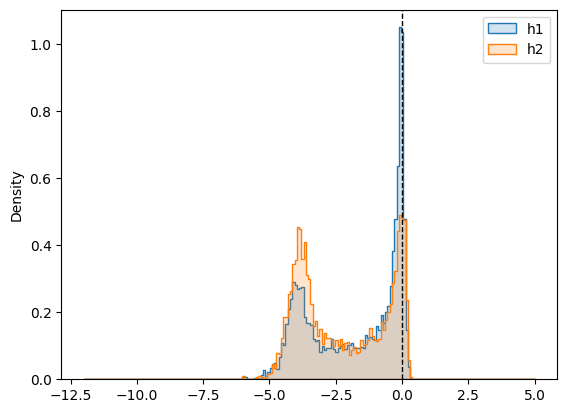

In [65]:
for d, data_set in data_sets.items():
    sns.histplot(x=data_set.functional_scores, label=d, fill=True, alpha=0.2, element="step", bins=np.linspace(-12, 5, 200), stat="density")
plt.axvline(0, color="black", linestyle="--", lw=1)
plt.legend()
plt.show()

## Fit model

In [66]:
model, loss_trajectory = multidms.jaxmodels.fit(
    data_sets,
    multidms_data.reference,
    l2reg=l2reg,
    fusionreg=fusionreg,
    block_iters=block_iters,
    block_tol=block_tol,
    ge_kwargs=dict(
        tol=ge_tol,
        maxiter=ge_maxiter,
        maxls=ge_maxls,
        jit=True,
        # verbose=False
        ),
    cal_kwargs=dict(
        tol=cal_tol,
        maxiter=cal_maxiter,
        maxls=cal_maxls,
        jit=True,
        # verbose=False
        ),
    loss_fn=loss_fn,
    global_epistasis=global_epistasis,
    loss_kwargs=loss_kwargs,
    warmstart=warmstart,
    beta_naught_init=beta_naught_init,
    beta_clip_range=beta_clip
    )

iter 1:
  calibration block: error=0.00e+00, stepsize=2.0e+00, iter=1
    h1: α=1.00, θ=1.00
    h2: α=1.00, θ=1.00
  β0 block: error=0.00e+00, stepsize=2.0e+00, iter=1
    h1: β0=5.00
    h2: β0=0.00
  β_nonbundle: error=5.59e-05, stepsize=6.6e+04, iter=100
  β_bundle: error=2.91e-04, stepsize=6.4e+01, iter=100
  h2 sparsity=97.9%
  obj=6.46e-01
  objective_error=3.54e-01
iter 2:
  calibration block: error=1.14e-10, stepsize=8.0e+00, iter=100
    h1: α=2.96, θ=1.00
    h2: α=3.42, θ=1.00
  β0 block: error=7.20e-10, stepsize=1.6e+01, iter=100
    h1: β0=8.35
    h2: β0=2.32
  β_nonbundle: error=1.13e-05, stepsize=8.2e+03, iter=100
  β_bundle: error=6.33e-04, stepsize=1.6e+01, iter=100
  h2 sparsity=60.7%
  obj=1.00e-01
  objective_error=5.46e-01
iter 3:
  calibration block: error=9.78e-10, stepsize=1.6e+01, iter=100
    h1: α=3.71, θ=1.00
    h2: α=3.80, θ=1.00
  β0 block: error=2.33e-10, stepsize=6.4e+01, iter=100
    h1: β0=8.86
    h2: β0=2.68
  β_nonbundle: error=3.90e-05, stepsize

## Loss trajectory

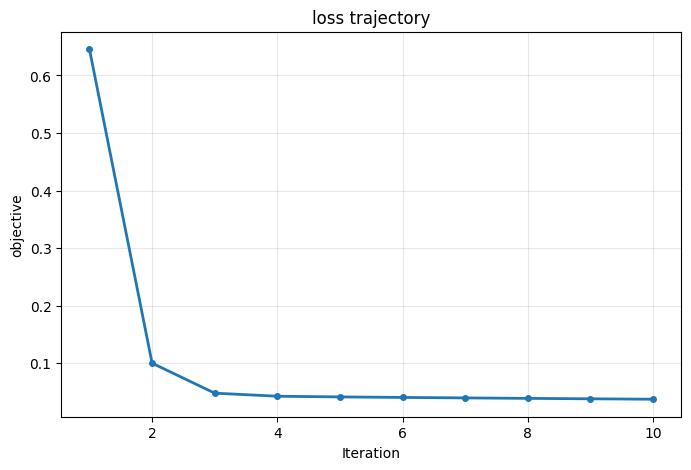

Final loss: 0.037351
Total iterations: 10


In [67]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(loss_trajectory) + 1), loss_trajectory, 'o-', linewidth=2, markersize=4)
plt.xlabel('Iteration')
plt.ylabel('objective')
plt.title('loss trajectory')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Final loss: {loss_trajectory[-1]:.6f}")
print(f"Total iterations: {len(loss_trajectory)}")


$\beta$ shift distributions

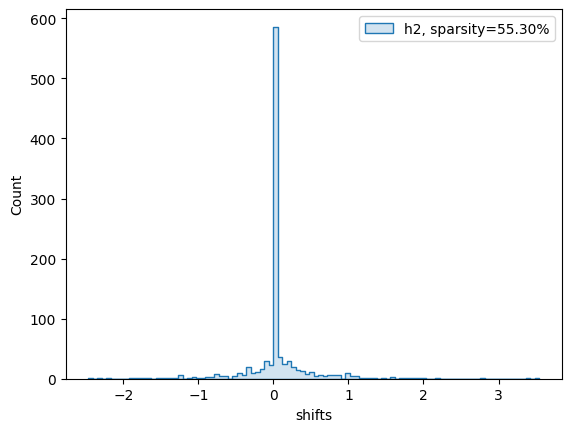

In [68]:
for d in data_sets:
    if d != model.reference_condition:
        shifts = model.φ[d].β - model.φ[model.reference_condition].β
        sns.histplot(
            x=shifts,
            bins=100,
            label=f"{d}, sparsity={(shifts == 0).sum() / len(shifts):.2%}", fill=True, alpha=0.2, element="step")
plt.legend()
plt.xlabel("shifts")
plt.show()

Read in ground truth mut effects

In [69]:
simu_mut_effects = pd.read_csv("simulated_muteffects.csv", keep_default_na=False)
simu_mut_effects

,mutation,beta_h1,wt_aa,site,mut_aa,shifted_site,shift,beta_h2,wt_aa_h1,wt_aa_h2,bundle_mut
0,G1A,-2.981264,G,1,A,False,0.0,-2.981264,G,G,False
1,G1C,-5.609745,G,1,C,False,0.0,-5.609745,G,G,False
2,G1D,-0.751102,G,1,D,False,0.0,-0.751102,G,G,False
3,G1E,-5.157105,G,1,E,False,0.0,-5.157105,G,G,False
4,G1F,-1.019324,G,1,F,False,0.0,-1.019324,G,G,False
...,...,...,...,...,...,...,...,...,...,...,...
995,G50T,1.934619,G,50,T,False,0.0,1.934619,G,G,False
996,G50V,-1.888492,G,50,V,False,0.0,-1.888492,G,G,False
997,G50W,1.070726,G,50,W,False,0.0,1.070726,G,G,False
998,G50Y,-9.847493,G,50,Y,False,0.0,-9.847493,G,G,False


Find ground truth sparsity

In [70]:
# how many shifts are equal to zero in simulated mut effects
zero_shift_df = simu_mut_effects[simu_mut_effects["shift"] == 0]
display(zero_shift_df)
(zero_shift_df.shape[0], simu_mut_effects.shape[0], zero_shift_df.shape[0] / simu_mut_effects.shape[0])

,mutation,beta_h1,wt_aa,site,mut_aa,shifted_site,shift,beta_h2,wt_aa_h1,wt_aa_h2,bundle_mut
0,G1A,-2.981264,G,1,A,False,0.0,-2.981264,G,G,False
1,G1C,-5.609745,G,1,C,False,0.0,-5.609745,G,G,False
2,G1D,-0.751102,G,1,D,False,0.0,-0.751102,G,G,False
3,G1E,-5.157105,G,1,E,False,0.0,-5.157105,G,G,False
4,G1F,-1.019324,G,1,F,False,0.0,-1.019324,G,G,False
...,...,...,...,...,...,...,...,...,...,...,...
995,G50T,1.934619,G,50,T,False,0.0,1.934619,G,G,False
996,G50V,-1.888492,G,50,V,False,0.0,-1.888492,G,G,False
997,G50W,1.070726,G,50,W,False,0.0,1.070726,G,G,False
998,G50Y,-9.847493,G,50,Y,False,0.0,-9.847493,G,G,False


(810, 1000, 0.81)

Functional score correlations

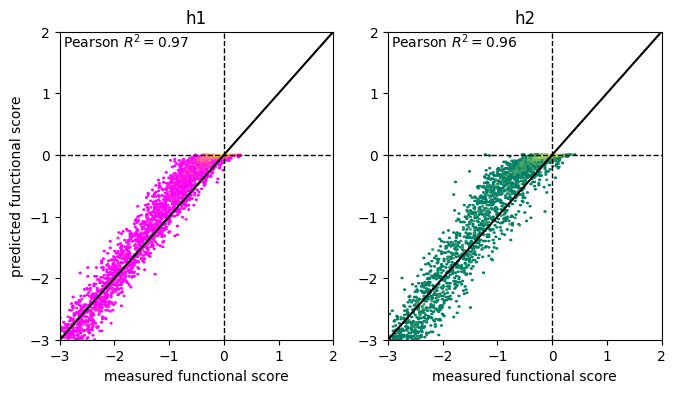

In [71]:
y_preds = model.predict_score(data_sets)

plt.figure(figsize=(12, 4))
ax = None
cmaps = ["spring", "summer", "autumn"]
colors = ["magenta", "green", "red"]
for i, (d, data_set) in enumerate(data_sets.items()):

    X = data_set.X
    x_wt = data_set.x_wt
    y = data_set.functional_scores
    y_pred = y_preds[d]

    ax = plt.subplot(1, 3, i + 1, sharex=ax, sharey=ax)
    plt.hexbin(y, y_pred, cmap=cmaps[i], gridsize=200, bins="log")
    # plt.scatter(y, y_pred, c=colors[i], s=0.1, alpha=0.5)
    plt.annotate(f"Pearson $R^2={scipy.stats.pearsonr(y, y_pred).statistic**2:.2f}$",
                 fontsize=10,
                 xy=(0.01, 0.95), xycoords="axes fraction")
    plt.plot([-10, 4], [-10, 4], "k")
    plt.axhline(0, color="k", linestyle="--", lw=1)
    plt.axvline(0, color="k", linestyle="--", lw=1)
    plt.xlim(-3, 2)
    plt.ylim(-3, 2)
    plt.xlabel("measured functional score")
    if i == 0:
        plt.ylabel("predicted functional score")
    plt.title(d)

plt.show()

Fitness landscape

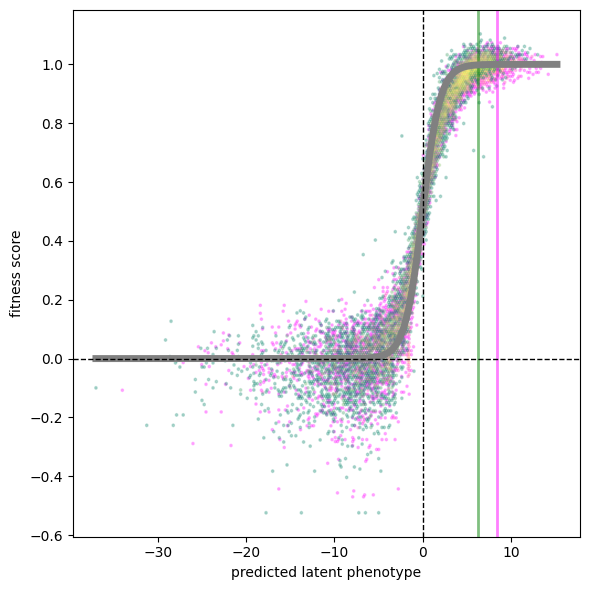

In [72]:
plt.figure(figsize=(6, 6))
φ_min = np.inf
φ_max = -np.inf
for i, (d, data_set) in enumerate(data_sets.items()):
    X = data_set.X
    x_wt = data_set.x_wt
    φ = model.φ[d]
    α = model.α[d]
    φ_pred = φ(X)
    φ_min = min(φ_min, φ_pred.min())
    φ_max = max(φ_max, φ_pred.max())
    φ_pred_wt = φ(x_wt)
    y = data_set.functional_scores
    f = y / α + model.global_epistasis(φ(x_wt))
    # plt.scatter(φ_pred, f, color=colors[i], s=0.1, alpha=0.5)
    plt.hexbin(φ_pred, f, cmap=cmaps[i], bins="log", gridsize=200, alpha=0.25)
    plt.axvline(φ_pred_wt, color=colors[i], lw=2, alpha=0.5)

# plot the global epistasis function
φ_grid = np.linspace(φ_min, φ_max, 1000)
plt.plot(φ_grid, model.global_epistasis(φ_grid), "grey", lw=5, label=r"$g(\phi)$")
plt.axhline(0, color="k", linestyle="--", lw=1)
plt.axvline(0, color="k", linestyle="--", lw=1)
plt.xlabel("predicted latent phenotype")
plt.ylabel("fitness score")
plt.tight_layout()
plt.show()

Joint plots of $\beta$ between conditions

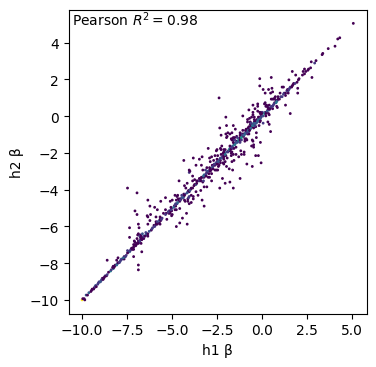

In [73]:
plt.figure(figsize=(4, 7))


plt.subplot(211)
plt.hexbin(model.φ["h1"].β, model.φ["h2"].β, bins="log", gridsize=200)
r = scipy.stats.pearsonr(model.φ["h1"].β, model.φ["h2"].β).statistic
plt.annotate(f"Pearson $R^2={r**2:.2f}$",
             fontsize=10,
             xy=(0.01, 0.95), xycoords="axes fraction")
# plt.axvline(0, color="black", linestyle="--", lw=1, zorder=0)
# plt.axhline(0, color="black", linestyle="--", lw=1, zorder=0)
plt.xlabel("h1 β")
plt.ylabel("h2 β")

plt.tight_layout()
plt.show()

In [74]:
model.α

{'h1': Array(4.08263704, dtype=float64),
 'h2': Array(3.94194165, dtype=float64)}

Distribution of $\beta$

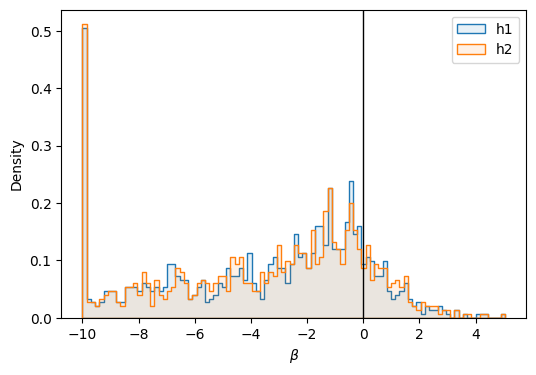

In [75]:
plt.figure(figsize=(6, 4))
for d in model.φ:
    sns.histplot(x=model.φ[d].β, label=d, bins=100, element="step", fill=True, alpha=0.1, stat="density")
plt.axvline(0, color="black", linestyle="-", lw=1)
plt.xlabel(r"$\beta$")
plt.legend()
plt.show()

Compile parameters into dataframe

In [76]:
mutations_df = multidms_data.mutations_df
mutations_df

,mutation,wts,sites,muts,times_seen_h1,times_seen_h2
0,F1A,F,1,A,21,17
1,F1C,F,1,C,9,8
2,F1D,F,1,D,11,8
3,F1E,F,1,E,8,9
4,F1G,F,1,G,22,19
...,...,...,...,...,...,...
995,E50T,E,50,T,24,20
996,E50V,E,50,V,26,21
997,E50W,E,50,W,8,8
998,E50Y,E,50,Y,11,9


In [77]:
len(multidms_data.mutations), data_sets["h1"].X.shape

(1000, (6575, 1000))

In [78]:
for d in multidms_data.conditions:
    # add betas to mut dataframe
    mutations_df[f"beta_{d}"] = model.φ[d].β
    # add shifts to mut dataframe
    if d != multidms_data.reference:
        mutations_df[f"shift_{d}"] = model.φ[d].β - model.φ[multidms_data.reference].β

# mutations_df.to_csv(f"{output_dir}/mutations_df.csv", index=False)
mutations_df = (
    mutations_df
    .drop(["wts", "sites", "muts"], axis=1)
    .set_index("mutation")
)
mutations_df

,times_seen_h1,times_seen_h2,beta_h1,beta_h2,shift_h2
mutation,,,,,
F1A,21,17,-3.092935,-3.846090,-0.753155
F1C,9,8,-1.334002,-1.334002,0.000000
F1D,11,8,-4.564023,-4.996357,-0.432334
F1E,8,9,-3.235678,-3.235678,0.000000
F1G,22,19,-7.854059,-7.854059,0.000000
...,...,...,...,...,...
E50T,24,20,-1.698273,-1.698273,0.000000
E50V,26,21,-1.619339,-1.769004,-0.149665
E50W,8,8,-1.183008,-1.183008,0.000000


In [79]:
simu_mut_effects = (
    simu_mut_effects
    .drop(["wt_aa", "site", "mut_aa"], axis=1)
    .set_index("mutation")
    .rename(
        columns={
            "shift": "simulated_shift",
            "beta_h1": "simulated_beta_h1",
            "beta_h2": "simulated_beta_h2"
        }
    )
)
simu_mut_effects

,simulated_beta_h1,shifted_site,simulated_shift,simulated_beta_h2,wt_aa_h1,wt_aa_h2,bundle_mut
mutation,,,,,,,
G1A,-2.981264,False,0.0,-2.981264,G,G,False
G1C,-5.609745,False,0.0,-5.609745,G,G,False
G1D,-0.751102,False,0.0,-0.751102,G,G,False
G1E,-5.157105,False,0.0,-5.157105,G,G,False
G1F,-1.019324,False,0.0,-1.019324,G,G,False
...,...,...,...,...,...,...,...
G50T,1.934619,False,0.0,1.934619,G,G,False
G50V,-1.888492,False,0.0,-1.888492,G,G,False
G50W,1.070726,False,0.0,1.070726,G,G,False


In [80]:
set(simu_mut_effects.index.values) - set(mutations_df.index.values)

{'C31*',
 'C31A',
 'C31D',
 'C31E',
 'C31F',
 'C31G',
 'C31H',
 'C31I',
 'C31K',
 'C31L',
 'C31M',
 'C31N',
 'C31P',
 'C31Q',
 'C31R',
 'C31S',
 'C31T',
 'C31V',
 'C31W',
 'C31Y',
 'C32*',
 'C32A',
 'C32D',
 'C32E',
 'C32F',
 'C32G',
 'C32H',
 'C32I',
 'C32K',
 'C32L',
 'C32M',
 'C32N',
 'C32P',
 'C32Q',
 'C32R',
 'C32S',
 'C32T',
 'C32V',
 'C32W',
 'C32Y',
 'C34*',
 'C34A',
 'C34D',
 'C34E',
 'C34F',
 'C34G',
 'C34H',
 'C34I',
 'C34K',
 'C34L',
 'C34M',
 'C34N',
 'C34P',
 'C34Q',
 'C34R',
 'C34S',
 'C34T',
 'C34V',
 'C34W',
 'C34Y',
 'C44*',
 'C44A',
 'C44D',
 'C44E',
 'C44F',
 'C44G',
 'C44H',
 'C44I',
 'C44K',
 'C44L',
 'C44M',
 'C44N',
 'C44P',
 'C44Q',
 'C44R',
 'C44S',
 'C44T',
 'C44V',
 'C44W',
 'C44Y',
 'D29*',
 'D29A',
 'D29C',
 'D29E',
 'D29F',
 'D29G',
 'D29H',
 'D29I',
 'D29K',
 'D29L',
 'D29M',
 'D29N',
 'D29P',
 'D29Q',
 'D29R',
 'D29S',
 'D29T',
 'D29V',
 'D29W',
 'D29Y',
 'F15*',
 'F15A',
 'F15C',
 'F15D',
 'F15E',
 'F15G',
 'F15H',
 'F15I',
 'F15K',
 'F15L',
 'F15M',
 

In [81]:
# merge the simulated mut effects with the inferred mut effects
merged_df = simu_mut_effects.join(mutations_df, how="inner")
merged_df

,simulated_beta_h1,shifted_site,simulated_shift,simulated_beta_h2,wt_aa_h1,wt_aa_h2,bundle_mut,times_seen_h1,times_seen_h2,beta_h1,beta_h2,shift_h2
mutation,,,,,,,,,,,,
S5A,-9.629777,False,0.0,-9.629777,S,S,False,22,17,-0.449396,-0.166561,0.282835
S5C,-2.324649,False,0.0,-2.324649,S,S,False,12,11,-3.247574,-3.188210,0.059364
S5D,0.268814,False,0.0,0.268814,S,S,False,16,7,2.911818,2.911818,0.000000
S5E,-3.199529,False,0.0,-3.199529,S,S,False,9,14,-4.676143,-4.676143,0.000000
S5F,-6.706652,False,0.0,-6.706652,S,S,False,7,7,-1.395047,-1.395047,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
L49T,-6.506198,False,0.0,-6.506198,L,V,False,18,18,-3.415176,-3.415176,0.000000
L49V,0.996403,False,0.0,0.996403,L,V,True,25,24,-1.052499,-1.135156,-0.082657
L49W,-2.430100,False,0.0,-2.430100,L,V,False,7,6,0.735145,0.735145,0.000000


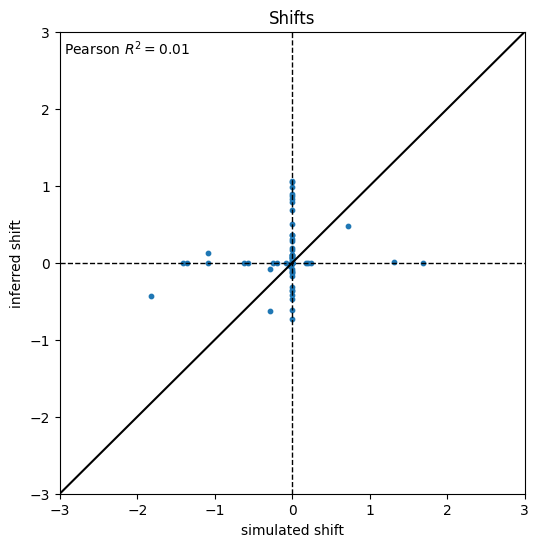

In [82]:
# plot inferred shifts vs simulated shifts for h2
plt.figure(figsize=(6, 6))
x = merged_df["simulated_shift"]
y = merged_df["shift_h2"]
plt.scatter(x, y, alpha=1, s=10)
r = scipy.stats.pearsonr(x, y).statistic
plt.annotate(f"Pearson $R^2={r**2:.2f}$",
                fontsize=10,
                xy=(0.01, 0.95), xycoords="axes fraction")
plt.plot([-3, 3], [-3, 3], "k")
plt.axhline(0, color="k", linestyle="--", lw=1)
plt.axvline(0, color="k", linestyle="--", lw=1)
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.xlabel("simulated shift")
plt.ylabel("inferred shift")
plt.title("Shifts")
plt.show()

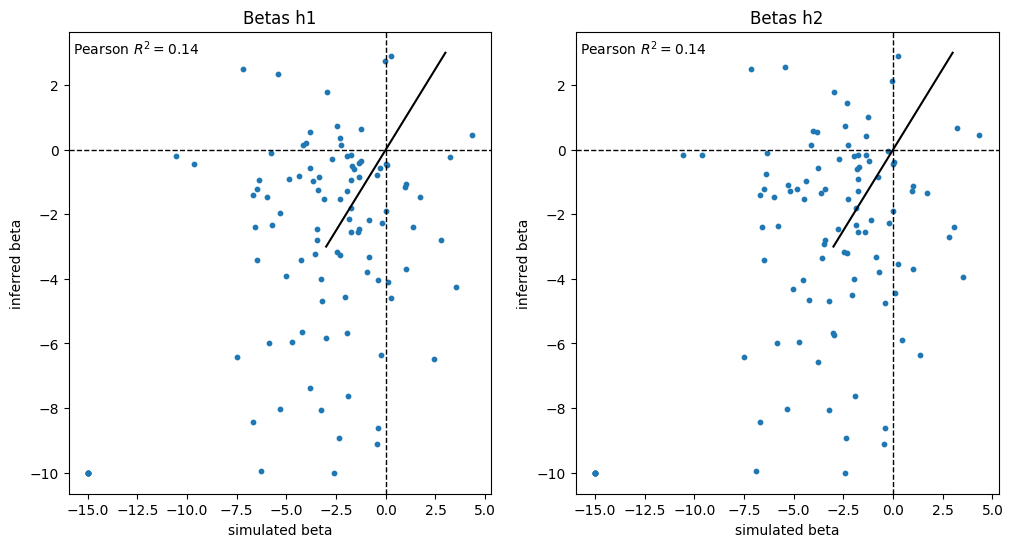

In [83]:
# plot inferred betas vs simulated betas for both h1 and h2
plt.figure(figsize=(12, 6))
for i, d in enumerate(["h1", "h2"]):
    plt.subplot(1, 2, i + 1)
    x = merged_df[f"simulated_beta_{d}"]
    y = merged_df[f"beta_{d}"]
    plt.scatter(x, y, alpha=1, s=10)
    r = scipy.stats.pearsonr(x, y).statistic
    plt.annotate(f"Pearson $R^2={r**2:.2f}$",
                 fontsize=10,
                 xy=(0.01, 0.95), xycoords="axes fraction")
    plt.plot([-3, 3], [-3, 3], "k")
    plt.axhline(0, color="k", linestyle="--", lw=1)
    plt.axvline(0, color="k", linestyle="--", lw=1)
    # plt.xlim(-3, 3)
    # plt.ylim(-3, 3)
    plt.xlabel("simulated beta")
    plt.ylabel("inferred beta")
    plt.title(f"Betas {d}")